In [2]:
import os 
import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt 
from io import BytesIO
from ipywidgets import widgets

In [3]:
BASE_DIR='data'

data_train='data/train'

print(f"Base Directory: {os.listdir(BASE_DIR)}")

print(f"Data Directory: {os.listdir(data_train)}")

Base Directory: ['train', 'val']
Data Directory: ['angular_leaf_spot', 'bean_rust', 'healthy']


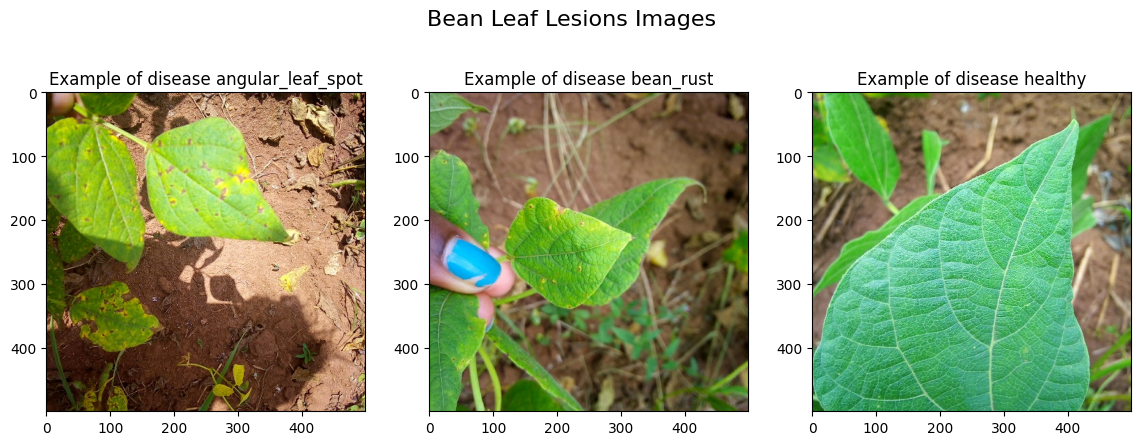

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(14, 5))
fig.suptitle('Bean Leaf Lesions Images', fontsize=16)

# Plot one image from the first 4 letters
for ii, disease in enumerate(['angular_leaf_spot' , 'bean_rust', 'healthy']):
    dir = f'./data/train/{disease}'
    img = tf.keras.preprocessing.image.load_img(dir+'/'+os.listdir(dir)[0])
    axes[ii].imshow(img)
    axes[ii].set_title(f'Example of disease {disease}')

In [ ]:
sample_array=tf.keras.preprocessing.image.img_to_array(img)
print(f"Each image has size: {sample_array.shape}")

Each image has size: (500, 500, 3)


In [ ]:
sample_array[0,:5]

array([[115., 110.,  68.],
       [119., 114.,  72.],
       [118., 113.,  71.],
       [115., 113.,  65.],
       [112., 117.,  61.]], dtype=float32)

In [36]:
#create model
def create_model():
    model=tf.keras.models.Sequential([
        tf.keras.Input(shape=(300,300,3)),
        tf.keras.layers.Rescaling(1./255),
        
        tf.keras.layers.Conv2D(16,(3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(16,(3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(32,(3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(32,(3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(64,(3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Flatten(),
        
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.2), 
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy'] 
    )
    return model


In [37]:
model_base=create_model()
model_base.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_8 (Rescaling)         │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 298, 298, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 149, 149, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 147, 147, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_43 (MaxPooling2D) │ (None, 73, 73, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 71, 71, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_44 (MaxPooling2D) │ (None, 35, 35, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 33, 33, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_45 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_46 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 437,075 (1.67 MB)

 Trainable params: 437,075 (1.67 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
BATCH_SIZE=32
IMAGE_SIZE=(300,300)
LABEL_MODE='categorical'

# Inisiasi Dataset
train_dataset,validation_dataset=tf.keras.utils.image_dataset_from_directory(
    data_train,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode=LABEL_MODE,
    validation_split=0.2, #20% data untuk validasi
    subset='both',
    seed=42 
)

Found 1034 files belonging to 3 classes.


Using 828 files for training.
Using 206 files for validation.


In [39]:
#Optimasi
SHUFFLE_BUFFER_SIZE=500
PREFETCH_BUFFER_SIZE=tf.data.AUTOTUNE

train_dataset_final=(
    train_dataset
    .cache()
    .shuffle(SHUFFLE_BUFFER_SIZE)
    .prefetch(PREFETCH_BUFFER_SIZE)
)

validation_dataset_final=(
    validation_dataset
    .cache()
    .prefetch(PREFETCH_BUFFER_SIZE)
)


In [40]:
class EarlyStoppingCallback(tf.keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs=None):
       
        train_accuracy = logs.get('accuracy')
        val_accuracy = logs.get('val_accuracy')
        if train_accuracy >= 0.95 :
            self.model.stop_training = True

            print("\nReached 95% train accuracy and 80% validation accuracy, so cancelling training!")



In [41]:
#base model
base_model = create_model()

# Constant for epochs
EPOCHS = 100

# Train the model
history = base_model.fit(
      train_dataset_final,
      epochs=EPOCHS,
      verbose=1,
      validation_data = validation_dataset_final,
      callbacks = [EarlyStoppingCallback()])


Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 242ms/step - accuracy: 0.3562 - loss: 1.1171 - val_accuracy: 0.5534 - val_loss: 1.0693
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 226ms/step - accuracy: 0.4735 - loss: 1.0391 - val_accuracy: 0.6117 - val_loss: 0.9348
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 230ms/step - accuracy: 0.5050 - loss: 1.0140 - val_accuracy: 0.5825 - val_loss: 0.9217
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 231ms/step - accuracy: 0.6239 - loss: 0.8540 - val_accuracy: 0.6650 - val_loss: 0.7951
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 242ms/step - accuracy: 0.6204 - loss: 0.8439 - val_accuracy: 0.6068 - val_loss: 0.8146
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 233ms/step - accuracy: 0.6620 - loss: 0.8009 - val_accuracy: 0.7087 - val_loss: 0.7156
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 216ms/step - accuracy: 0.6830 - loss: 0.7064 - val_accuracy: 0.7427 - val_loss: 0.6470
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 221ms/step - accuracy: 0.6926 - loss: 0.6983 - val_accu

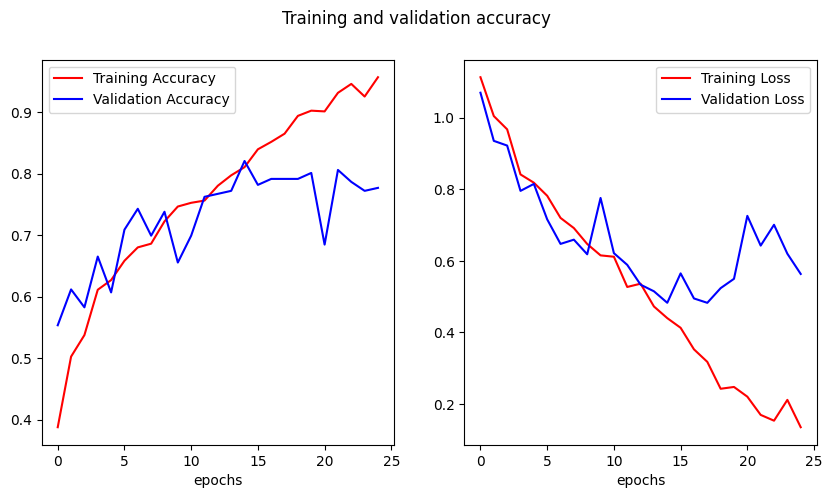

In [42]:
# Get training and validation accuracies
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()

Augmentasi

In [94]:
FILL_MODE='nearest'

data_augmentation=tf.keras.Sequential([
    tf.keras.Input(shape=(300,300,3)),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2, fill_mode=FILL_MODE),
    tf.keras.layers.RandomTranslation(0.2, 0.2, fill_mode=FILL_MODE),
    tf.keras.layers.RandomZoom(0.2, fill_mode=FILL_MODE)
])

In [95]:
base_model=create_model()
model_with_aug=tf.keras.models.Sequential([
    data_augmentation,
    base_model
])

model_with_aug.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])


In [96]:
# Constant for epochs
EPOCHS = 100

# Train the model
history_aug = model_with_aug.fit(
      train_dataset_final,
      epochs=EPOCHS,
      verbose=1,
      validation_data = validation_dataset_final,
      callbacks = [EarlyStoppingCallback()])

Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 14s 455ms/step - accuracy: 0.3791 - loss: 1.0789 - val_accuracy: 0.5874 - val_loss: 0.9612
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 422ms/step - accuracy: 0.5403 - loss: 0.9627 - val_accuracy: 0.6650 - val_loss: 0.8559
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 419ms/step - accuracy: 0.5406 - loss: 0.9152 - val_accuracy: 0.6796 - val_loss: 0.7908
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 420ms/step - accuracy: 0.6459 - loss: 0.7882 - val_accuracy: 0.5825 - val_loss: 0.9321
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 418ms/step - accuracy: 0.6434 - loss: 0.8101 - val_accuracy: 0.6553 - val_loss: 0.8750
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 420ms/step - accuracy: 0.6298 - loss: 0.8159 - val_accuracy: 0.6650 - val_loss: 0.7926
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 421ms/step - accuracy: 0.6101 - loss: 0.8170 - val_accuracy: 0.6942 - val_loss: 0.7453
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 422ms/step - accuracy: 0.6600 - loss: 0.7257 - 

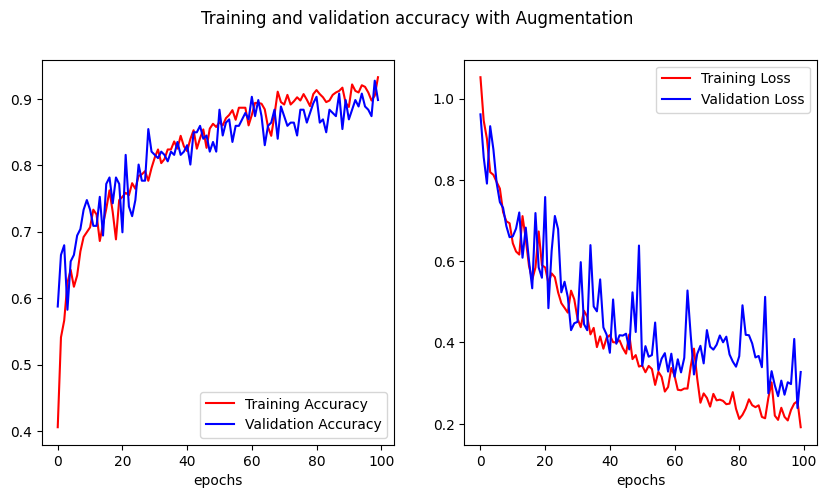

In [97]:
# Get training and validation accuracies
acc = history_aug.history['accuracy']
val_acc = history_aug.history['val_accuracy']
loss = history_aug.history['loss']
val_loss = history_aug.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy with Augmentation')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()

In [116]:
# Create the widget and take care of the display
uploader = widgets.FileUpload(accept="image/*", multiple=True)
display(uploader)
out = widgets.Output()
display(out)

def file_predict(filename, file, out):
    """ A function for creating the prediction and printing the output."""
    image = tf.keras.utils.load_img(file, target_size=(300, 300))
    image = tf.keras.utils.img_to_array(image)
    image = np.expand_dims(image, axis=0)
    
    prediction = model_with_aug.predict(image, verbose=0)[0][0]
    
    with out:
        print(prediction)
        if prediction > 0.5:
            print(filename + " is angular_leaf_spot")
        elif prediction < 0.0001:
            print(filename + " is healthy")
        elif prediction < 0.5:
            print(filename + " is bean_rust")
        
def on_upload_change(change):
    """ A function for geting files from the widget and running the prediction."""
    # Get the newly uploaded file(s)
    
    items = change.new
    for item in items: # Loop if there is more than one file uploaded  
        file_jpgdata = BytesIO(item.content)
        file_predict(item.name, file_jpgdata, out)


uploader.observe(on_upload_change, names='value')


FileUpload(value=(), accept='image/*', description='Upload', multiple=True)

Output()